# Project Title: E-commerce Analytics ML Hackathon

#### Author: Joanna Khek Cuina   
#### Date: 10 April 2020

With the evolution of the information and communication technologies and the rapid growth of the Internet for the exchange and distribution of information, Electronic Commerce (e-commerce) has gained massive momentum globally, and attracted more and more worldwide users overcoming the time constraints and distance barriers.

It is important to gain in-depth insights into e-commerce via data-driven analytics and identify the factors affecting product sales, the impact of characteristics of customers on their purchase habits.

It is quite useful to understand the demand, habits, concern, perception, and interest of customers from the clue of genders for e-commerce companies. 

However, the genders of users are in general unavailable in e-commerce platforms. To address this gap the aim here is to predict the gender of e-commerce’s participants from their product viewing records.

**Train file**: CSV containing the product viewing data with gender as label. Product list contains list of products viewed by the user in the given session and it also contains the category, sub category, sub-sub category and the product all encoded and separated with a slash symbol. Each consecutive product is separated with a semicolon.    

**Test file**: CSV containing sessions for which gender prediction is to be submitted. 

**Evaluation**" Submissions are evaluated on accuracy between the predicted and observed gender for the sessions in the test set.

## Import Libraries

In [477]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import missingno

# visualization
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

# model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,StackingClassifier,VotingClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

# evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.simplefilter('ignore')

In [478]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", -1)

## Import Data

In [479]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [480]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   session_id   10500 non-null  object
 1   startTime    10500 non-null  object
 2   endTime      10500 non-null  object
 3   ProductList  10500 non-null  object
 4   gender       10500 non-null  object
dtypes: object(5)
memory usage: 410.3+ KB


In [481]:
train.head()

,session_id,startTime,endTime,ProductList,gender
0,u16159,15/12/14 18:11,15/12/14 18:12,A00002/B00003/C00006/D28435/;A00002/B00003/C00006/D02554/;A00002/B00003/C00006/D28436/;A00002/B00003/C00006/D28437/,female
1,u10253,16/12/14 14:35,16/12/14 14:41,A00001/B00009/C00031/D29404/;A00001/B00009/C00031/D02617/;A00001/B00009/C00031/D29407/;A00001/B00009/C00031/D29410/;A00001/B00009/C00031/D29411/;A00001/B00009/C00031/D25444/;A00001/B00009/C00031/D29418/,male
2,u19037,01/12/14 15:58,01/12/14 15:58,A00002/B00001/C00020/D16944/,female
3,u14556,23/11/14 2:57,23/11/14 3:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00018/D10285/;A00002/B00004/C00018/D10286/,female
4,u24295,17/12/14 16:44,17/12/14 16:46,A00001/B00001/C00012/D30805/;A00001/B00001/C00012/D30806/,male


In [482]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   session_id   4500 non-null   object
 1   startTime    4500 non-null   object
 2   endTime      4500 non-null   object
 3   ProductList  4500 non-null   object
dtypes: object(4)
memory usage: 140.8+ KB


In [483]:
test.head()

,session_id,startTime,endTime,ProductList
0,u12112,08/12/14 13:36,08/12/14 13:36,A00002/B00003/C00006/D19956/
1,u19725,19/12/14 13:52,19/12/14 13:52,A00002/B00005/C00067/D02026/
2,u11795,01/12/14 10:44,01/12/14 10:44,A00002/B00002/C00004/D12538/
3,u22639,08/12/14 20:19,08/12/14 20:22,A00002/B00003/C00079/D22781/;A00002/B00003/C00079/D22782/;A00002/B00003/C00079/D19325/;A00002/B00003/C00079/D22786/
4,u18034,15/12/14 19:33,15/12/14 19:33,A00002/B00001/C00010/D23419/


## Check for Missing Values

In [484]:
# check for missing values
miss = train.isnull().sum()/len(train)
miss = miss[miss > 0]
miss.sort_values(inplace=True)
miss

Series([], dtype: float64)

## Data Preprocessing

In [485]:
def preprocess(data):
    # convert starttime and endtime to datetime format
    data["startTime"] = pd.to_datetime(data["startTime"])
    data["endTime"] = pd.to_datetime(data["endTime"])
    print("Done: Convert to Datetime format")
    
    # get the number of sites visited
    data["total_products"] = data["ProductList"].apply(lambda x: len(x.split(";")))
    print("Done: Number of sites visited")
    
#     # extract product D group
#     data["D_group"] = data["ProductList"].apply(lambda x: re.search(r"D\d{3}", x).group(0))
#     print("Done: Extracting D Group")
    
    # extract the productlist
    temp = data["ProductList"].str.split(";")
    data = data.reindex(data.index.repeat(temp.apply(len)))
    data["product_data"] = np.hstack(temp)
    data['category'] = data["product_data"].str.split("/").str[0]
    data["sub_category"] = data["product_data"].str.split("/").str[1]
    data["sub_sub_category"] = data["product_data"].str.split("/").str[2]
    data["product"] = data["product_data"].str.split("/").str[3]
    #data["ProductList"] = data["ProductList"].apply(lambda x: x.replace(";",""))
    #data["ProductList"] = data["ProductList"].apply(lambda x: re.sub("\/D\d+", "", x))
#     columns = sorted(set(data['ProductList'].str.split('/').sum()))
#     for column in columns:
#         data[column] = data["ProductList"].str.count(column)
    print("Done: Extracting categories")
    
    # extract duration spent on website
    duration = data["endTime"] - data["startTime"]
    data["duration"] = duration.dt.seconds
    data["startTime_month"] = data["startTime"].dt.month
    data["startTime_date"] = data["startTime"].dt.date
    data["startTime_day"] = data["startTime"].dt.day
    data["startTime_doy"] = data["startTime"].dt.dayofyear
    data["startTime_week"] = data["startTime"].dt.week
    data["startTime_dow"] = data["startTime"].dt.dayofweek
    data["startTime_hour"] = data["startTime"].dt.hour
    data["startTime_minute"] = data["startTime"].dt.minute
    data["endTime_hour"] = data["endTime"].dt.hour
    data["endTime_minute"] = data["endTime"].dt.minute
    print("Done: Extracting duration spent on website")
    
    # total
    data["total_product_day"] = data.groupby(["startTime_day"])["total_products"].transform("sum")
    data["total_product_week"] = data.groupby(["startTime_week"])["total_products"].transform("sum")
    data["total_product_dow"] = data.groupby(["startTime_dow"])["total_products"].transform("sum")
    data["total_product_hour"] = data.groupby(["startTime_hour"])["total_products"].transform("sum")
    print("Done: Extracting total information")
                                              
    return data

In [486]:
train = preprocess(train)

Done: Convert to Datetime format
Done: Number of sites visited
Done: Extracting categories
Done: Extracting duration spent on website
Done: Extracting total information


In [487]:
test = preprocess(test)

Done: Convert to Datetime format
Done: Number of sites visited
Done: Extracting categories
Done: Extracting duration spent on website
Done: Extracting total information


In [488]:
# remove gender from training set first
train_df = train.drop("gender", axis=1)
y = train["gender"]

## Encoding Categorical

In [489]:
le_cat = LabelEncoder()
le_subcat = LabelEncoder()
le_subsubcat = LabelEncoder()
le_product = LabelEncoder()
le_gender = LabelEncoder()
le_session = LabelEncoder()

In [490]:
combined_data = train_df.append(test)

In [491]:
# fit on the combined data
combined_data["category"] = le_cat.fit_transform(combined_data["category"])
combined_data["sub_category"] = le_subcat.fit_transform(combined_data["sub_category"])
combined_data["sub_sub_category"] = le_subsubcat.fit_transform(combined_data["sub_sub_category"])
combined_data["product"] = le_product.fit_transform(combined_data["product"])
combined_data["session_id"] = le_session.fit_transform(combined_data["session_id"])
y = le_gender.fit_transform(y)

In [492]:
# apply transformation (train)
train_df["category"] = le_cat.transform(train_df["category"])
train_df["sub_category"] = le_subcat.transform(train_df["sub_category"])
train_df["sub_sub_category"] = le_subsubcat.transform(train_df["sub_sub_category"])
train_df["product"] = le_product.transform(train_df["product"])
train_df["session_id"] = le_session.transform(train_df["session_id"])

In [493]:
# apply transformation (test)
test["category"] = le_cat.transform(test["category"])
test["sub_category"] = le_subcat.transform(test["sub_category"])
test["sub_sub_category"] = le_subsubcat.transform(test["sub_sub_category"])
test["product"] = le_product.transform(test["product"])
test["session_id"] = le_session.transform(test["session_id"])

## Remove unnecessary columns

In [495]:
train_df = train_df.drop(["startTime", "endTime", "ProductList", "product_data", "startTime_date"], axis=1)
test = test.drop(["startTime", "endTime", "ProductList", "product_data", "startTime_date"], axis=1)

## SMOTE

In [58]:
# # concatenate our training data back together
# X = pd.concat([X_train, y_train], axis=1)

# # separate minority and majority classes
# male = X[X["gender"] == "male"]
# female = X[X["gender"] == "female"]

# # upsample minority
# male_upsampled = resample(male,
#                           replace = True, # sample with replacement
#                           n_samples = len(female), # match number in majority class)
#                           random_state = 101)

# # combine majority and upsample minority
# upsampled = pd.concat([female, male_upsampled])

# # check new class counts
# upsampled.gender.value_counts()

female    7372
male      7372
Name: gender, dtype: int64

In [59]:
# X_train = upsampled.drop("gender", axis=1)
# y_train = upsampled["gender"]

## Match Test Set Columns with Training Set Columns

In [62]:
# # get missing columns in training and test set
# missing_cols = set(train.columns) - set(test.columns)

# # add a missing column in test set with default value equal to 0
# for c in missing_cols:
#     test[c] = 0
    
# # ensure that order of column in the test set is in the same order than in train set
# test = test[train.columns]

In [63]:
# test = test.drop("gender", axis=1)

## Baseline Performance

In [388]:
def baseliner(features, target, cv=3, metric="accuracy"):
    print("Baseline Models\n")
    eval_dict = {}
    models = [lgb.LGBMClassifier(), xgb.XGBClassifier(), cat.CatBoostClassifier(verbose=0), GradientBoostingClassifier(), 
              LogisticRegression(), RandomForestClassifier(), DecisionTreeClassifier(), AdaBoostClassifier(),
              ExtraTreeClassifier(), ExtraTreesClassifier(), KNeighborsClassifier(), BaggingClassifier()]
    print("Model Name \t |    CV")
    print("--"*50)
    
    for index, model in enumerate(models, 0):
        model_name = str(model).split("(")[0]
        eval_dict[model_name] = {}
        
        results = cross_val_score(model, features, target, cv=cv, scoring=metric)
        eval_dict[model_name]["cv"] = results.mean()
        
        print("%s \t | %.4f \t" % (model_name[:12], eval_dict[model_name]["cv"]))

In [389]:
baseliner(train_df, y, cv=5, metric="accuracy")

Baseline Models

Model Name 	 |    CV
----------------------------------------------------------------------------------------------------
LGBMClassifi 	 | 0.8947 	
XGBClassifie 	 | 0.8876 	
<catboost.co 	 | 0.8966 	
GradientBoos 	 | 0.8878 	
LogisticRegr 	 | 0.7879 	
RandomForest 	 | 0.8937 	
DecisionTree 	 | 0.8338 	
AdaBoostClas 	 | 0.8820 	
ExtraTreeCla 	 | 0.7739 	
ExtraTreesCl 	 | 0.8788 	
KNeighborsCl 	 | 0.7517 	
BaggingClass 	 | 0.8881 	


## Training and Testing Set

In [497]:
rs = ShuffleSplit(n_splits=3, test_size=0.1, random_state=101)
test_prob_preds = np.zeros(test.shape[0])

## XGBoost Classifier

--------------------------------------------------------------------------------
Iteration Number : 0
[0]	train-error:0.093811	valid-error:0.11006
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 100 rounds.
[50]	train-error:0.059642	valid-error:0.087704
[100]	train-error:0.035699	valid-error:0.066208
[150]	train-error:0.019833	valid-error:0.052021
[200]	train-error:0.012951	valid-error:0.042562
[250]	train-error:0.007981	valid-error:0.039553
[300]	train-error:0.00454	valid-error:0.036114
[350]	train-error:0.002867	valid-error:0.033964
[400]	train-error:0.001577	valid-error:0.033534
[450]	train-error:0.000669	valid-error:0.033964
[500]	train-error:0.000239	valid-error:0.032674
[550]	train-error:9.6e-05	valid-error:0.032674
[600]	train-error:4.8e-05	valid-error:0.032244
[650]	train-error:0	valid-error:0.031384
[700]	train-error:0	valid-error:0.031384
[750]	train-error:0	valid-error:0.030525
Stopping. 

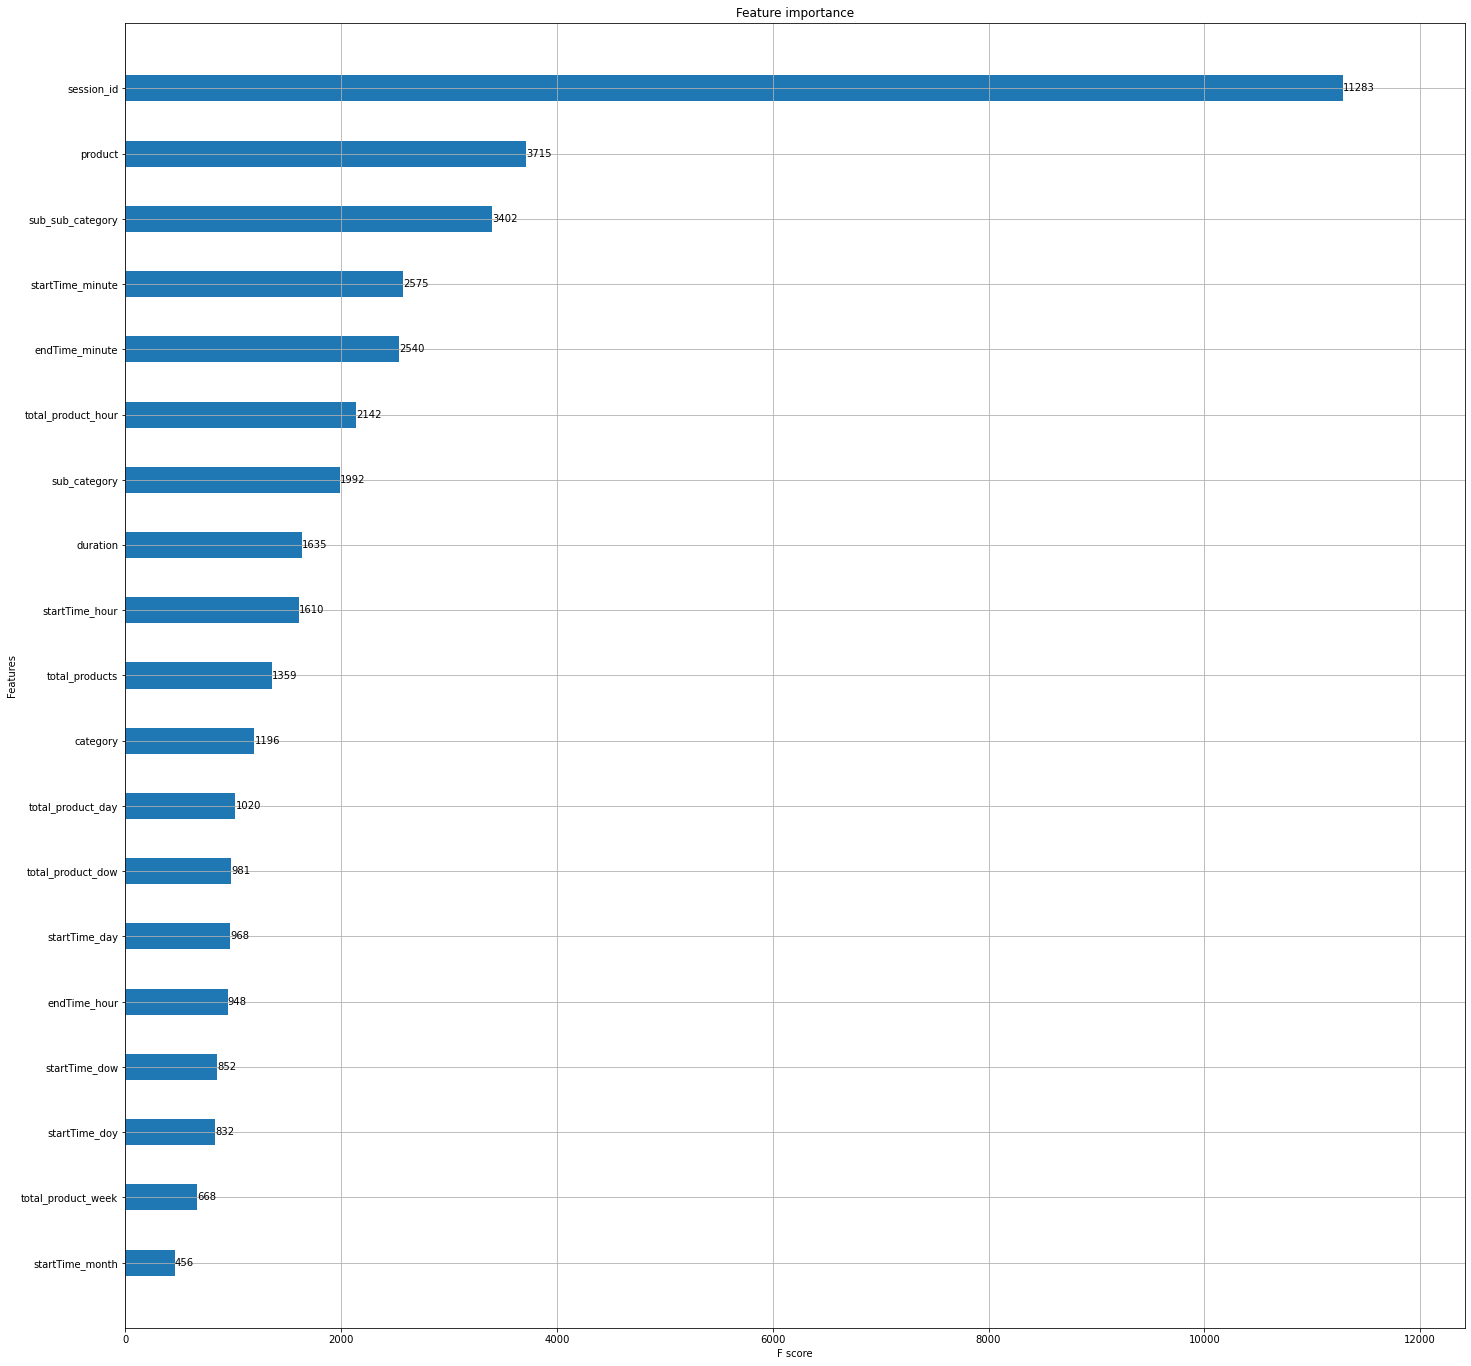

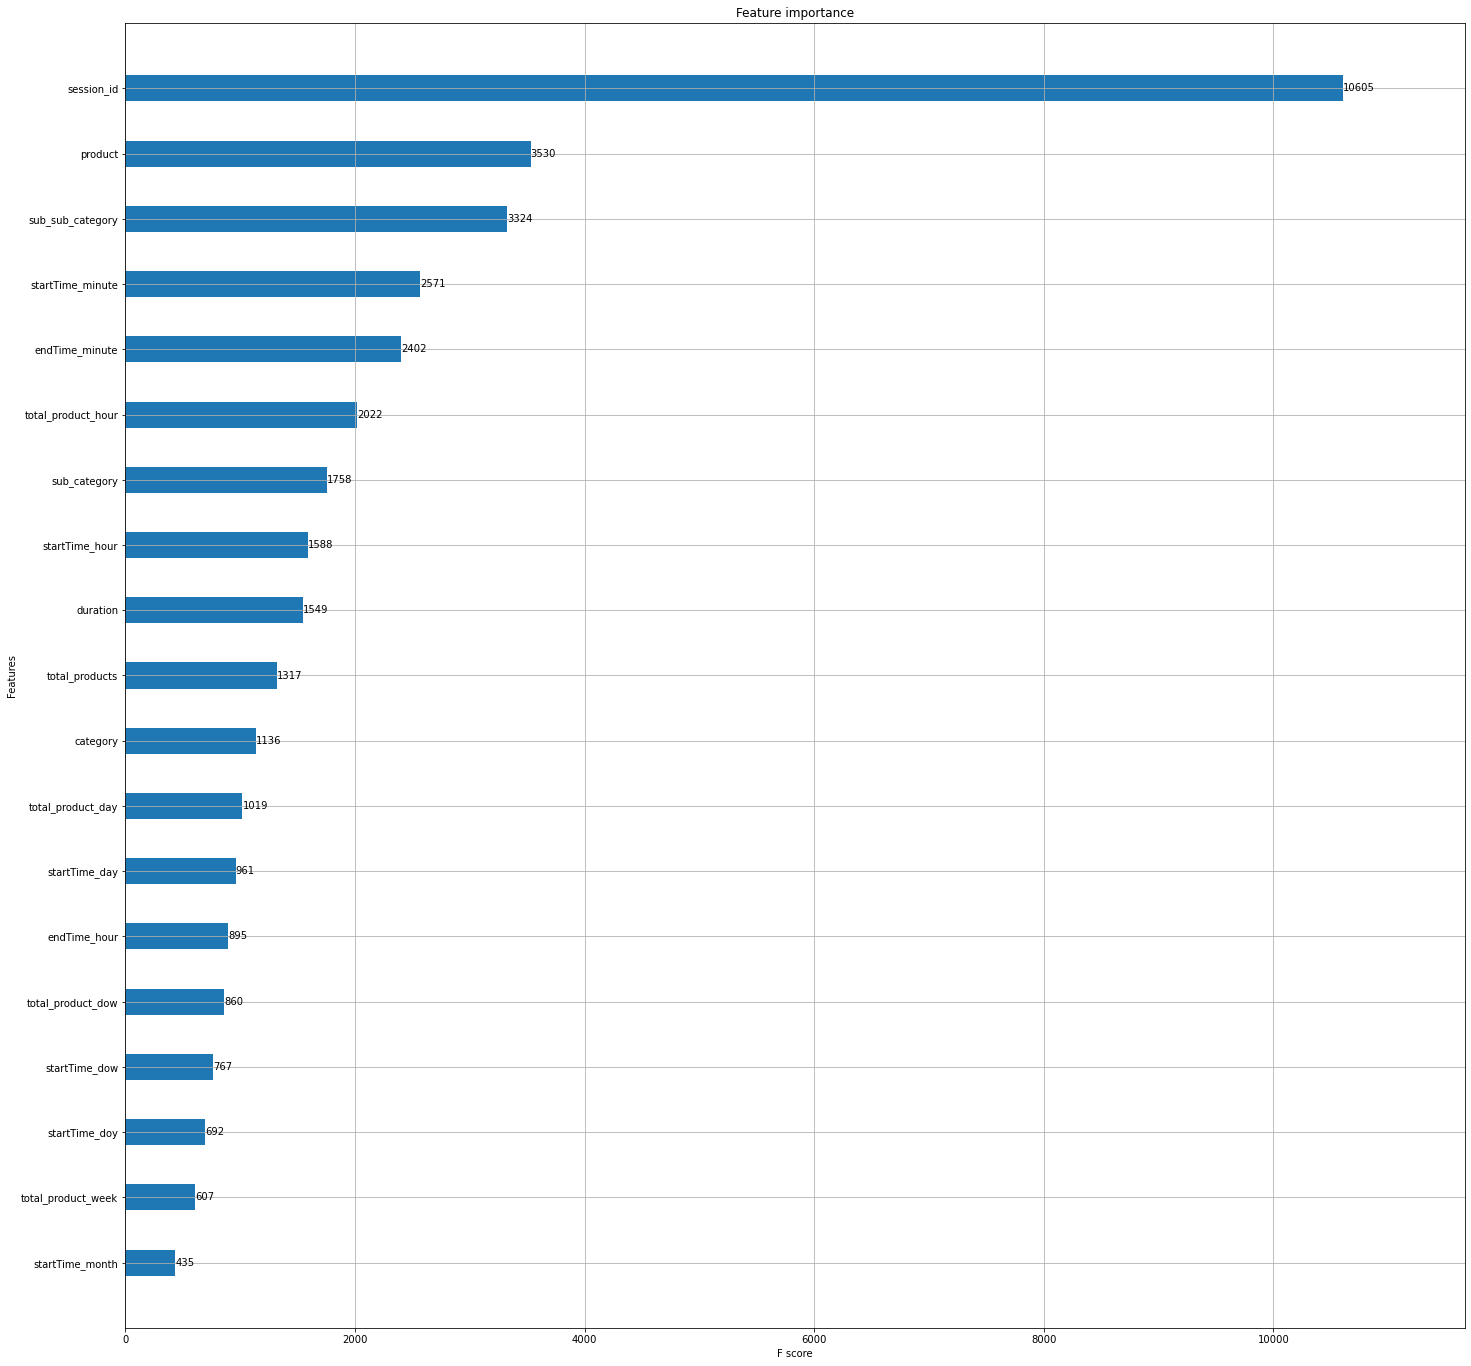

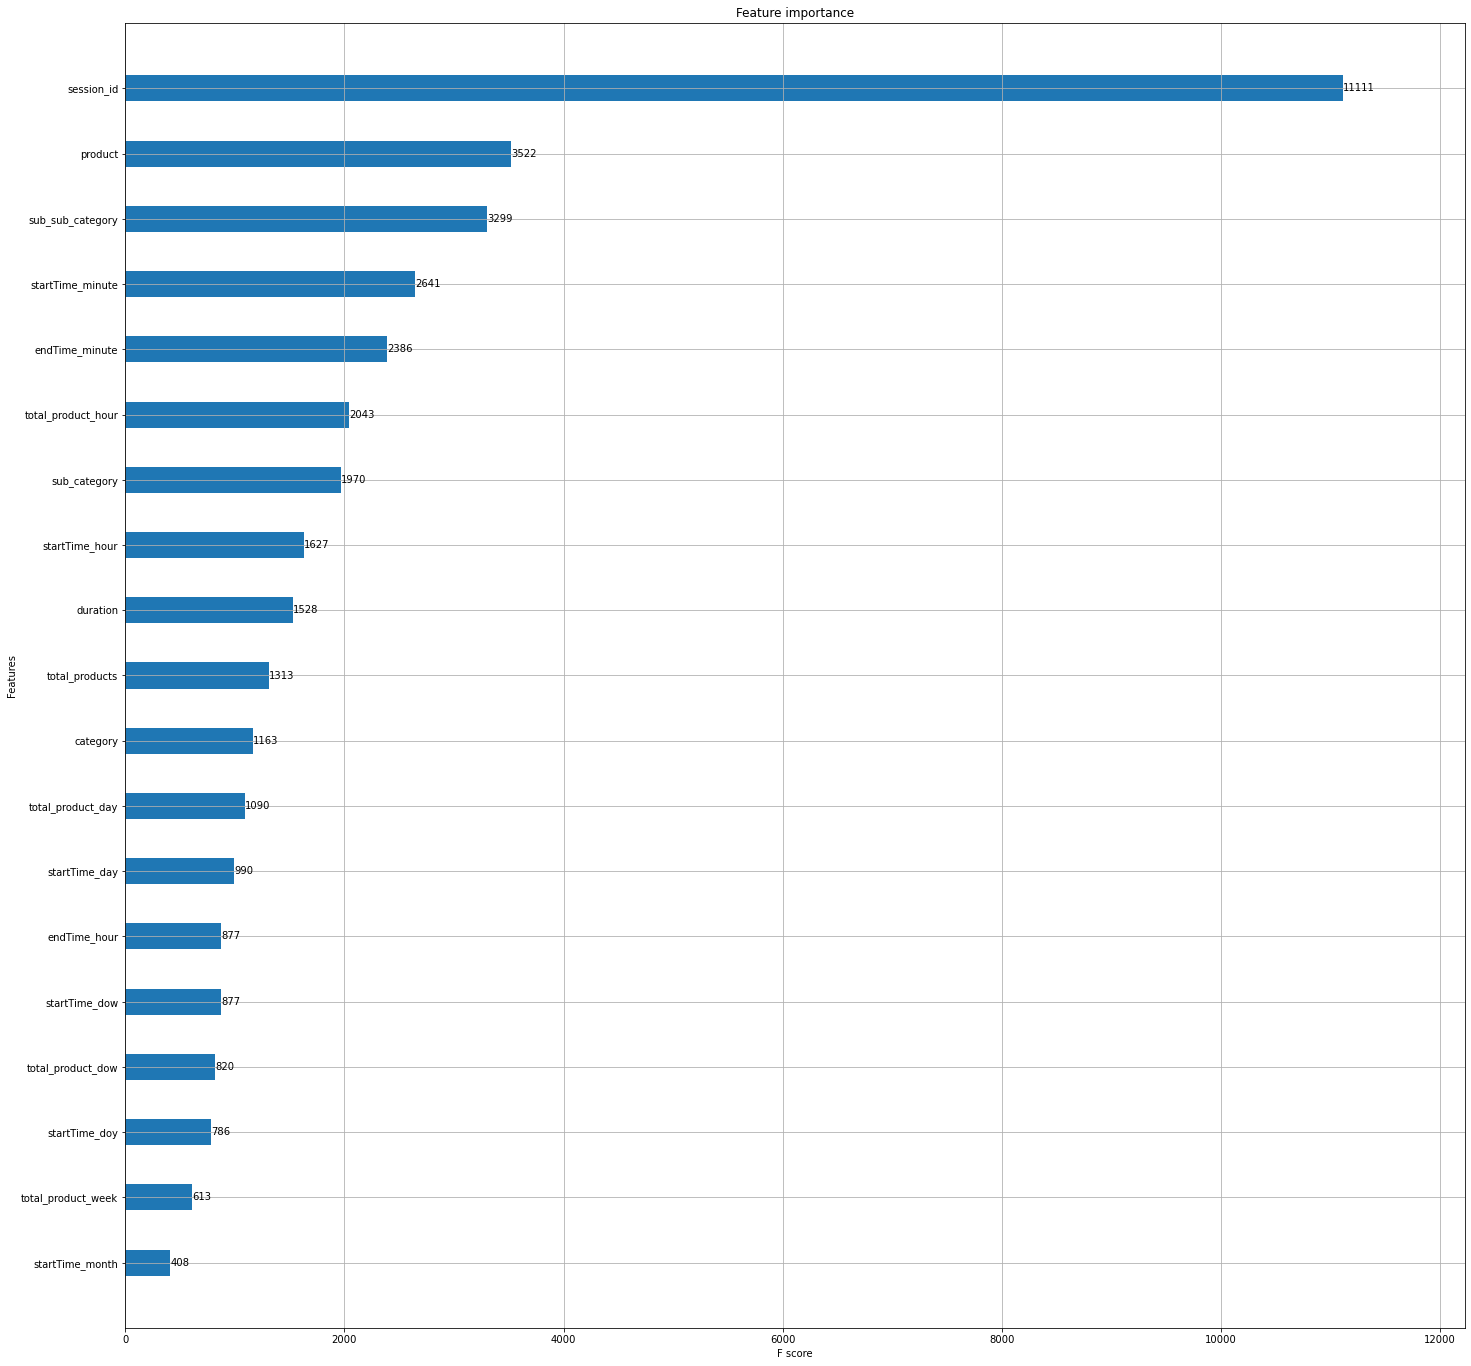

In [498]:
for idx, (train_idx, valid_idx) in enumerate(rs.split(train_df, pd.DataFrame(y))):
    print("--"*40)
    print("Iteration Number : {}".format(idx))
    MAX_ROUNDS=2000
    early_stopping_rounds=100
    params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'error',
        'learning_rate': 0.1,
        'num_round': MAX_ROUNDS,
        'max_depth': 8,
        'seed': 13,
        'nthread': -1
    }

    X_train, X_valid, y_train, y_valid = train_df.iloc[train_idx], train_df.iloc[valid_idx], pd.DataFrame(y).iloc[train_idx], pd.DataFrame(y).iloc[valid_idx]
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    
    model = xgb.train(
        params,
        dtrain,
        evals=watchlist,
        num_boost_round=MAX_ROUNDS,
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=50
    )
    
    print("Best Iteration :: {} \n".format(model.best_iteration))

    # Plotting Importances
    fig, ax = plt.subplots(figsize=(24, 24))
    xgb.plot_importance(model, height=0.4, ax=ax)
    preds = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit)
    
    test_prob_preds += preds
    
test_prob_preds /= rs.n_splits
print(test_prob_preds.shape, test_prob_preds[: 5])

In [499]:
test.head()

,session_id,total_products,category,sub_category,sub_sub_category,product,duration,startTime_month,startTime_day,startTime_doy,startTime_week,startTime_dow,startTime_hour,startTime_minute,endTime_hour,endTime_minute,total_product_day,total_product_week,total_product_dow,total_product_hour
0,2111,1,1,2,5,12675,0,8,12,224,33,1,13,36,13,36,13989,3857,7435,6444
1,9724,1,1,4,66,1407,0,12,19,353,51,4,13,52,13,52,1972,9599,8165,6444
2,1794,1,1,1,3,8129,0,1,12,12,2,6,10,44,10,44,13989,2347,6112,2969
3,12638,4,1,2,77,14345,180,8,12,224,33,1,20,19,20,22,13989,3857,7435,3464
3,12638,4,1,2,77,14346,180,8,12,224,33,1,20,19,20,22,13989,3857,7435,3464


In [500]:
# take the mean of the proabilities for all the session_ids to calculate male or female
test["predict_prob"] = test_prob_preds
test["session_id"] = le_session.inverse_transform(test["session_id"])
agg = test.groupby(["session_id"])["predict_prob"].mean().reset_index()

## Submission

In [501]:
sub = pd.read_csv("sample_submission.csv")
sub = sub.drop("gender", axis=1)
sub = pd.merge(sub, agg, on=["session_id"], how='left')

In [502]:
sub["gender"] = sub["predict_prob"].apply(lambda x: round(x))

In [503]:
sub["gender"] = sub["gender"].map({1: "male", 0: "female"})

In [504]:
sub = sub.drop("predict_prob", axis=1)

In [476]:
sub.to_submission("submission.csv")

,session_id,gender
0,u12112,female
1,u19725,female
2,u11795,female
3,u22639,male
4,u18034,male
